In [1]:
import json
import pathlib

from fastai.text import *

import numpy as np
import pandas as pd

# Data Preparation

In [2]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

PATH = pathlib.Path("lm/telugu/data/")

In [3]:
LM_PATH=Path('lm/telugu/telugu_lm/')
LM_PATH.mkdir(exist_ok=True)

In [273]:
LANG_FILENAMES = [str(f) for f in PATH.rglob("*/*")]
print(len(LANG_FILENAMES))
LANG_FILENAMES[0:5]

477


['lm/telugu/data/AD/wiki_98',
 'lm/telugu/data/AD/wiki_83',
 'lm/telugu/data/AD/wiki_52',
 'lm/telugu/data/AD/wiki_82',
 'lm/telugu/data/AD/wiki_21']

In [278]:
LANG_TEXT = []
for i in LANG_FILENAMES:
    for line in open(i, encoding='utf-16'):
        LANG_TEXT.append(json.loads(line))
        
LANG_TEXT = pd.DataFrame(LANG_TEXT)

UnicodeError: UTF-16 stream does not start with BOM

In [ ]:
LANG_TEXT.to_csv(f"{LM_PATH}/Wiki_Telugu_Corpus.csv", index=False)

In [279]:
LANG_TEXT = pd.read_csv(f"{LM_PATH}/Wiki_Telugu_Corpus.csv")

In [280]:
(LANG_TEXT.assign(labels = 0)
    .pipe(lambda x: x[['labels', 'text']])
    .to_csv(f"{LM_PATH}/Wiki_Telugu_Corpus2.csv", header=None, index=False))

# Some statistics of Telugu Wikipedia

In [281]:
# Getting rid of the title name in the text field
def split_title_from_text(text):
    words = text.split("\n\n")
    if len(words) >= 2:
        return ''.join(words[1:])
    else:
        return ''.join(words)
    
LANG_TEXT['text'] = LANG_TEXT['text'].apply(lambda x: split_title_from_text(x))

### Number of documents

In [282]:
LANG_TEXT.shape

(69001, 4)

### Number of words in all the documents

In [283]:
LANG_TEXT['text'].apply(lambda x: len(x.split(" "))).sum()

22174830

### Number of unique tokens across documents

In [284]:
len(set(''.join(LANG_TEXT['text'].values).split(" ")))

2023536

In [285]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    #texts = texts.apply(fixup).values.astype(str)

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts)) # splits the list into sublists for processing by each core
    # Lower and upper case is inside the tokenizer
    return tok, list(labels)

def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        #pdb.set_trace()
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [286]:
LANG_TEXT = pd.read_csv(f"{LM_PATH}/Wiki_Telugu_Corpus2.csv", header=None)#, chunksize=5000)

In [287]:
trn_texts,val_texts = sklearn.model_selection.train_test_split(
    LANG_TEXT, test_size=0.1) # split the data into train and validation sets

In [288]:
np.random.seed(42)
trn_idx = np.random.permutation(len(trn_texts)) # generate a random ordering
val_idx = np.random.permutation(len(val_texts))

df_trn = trn_texts.iloc[trn_idx,:] # sort things randomly
df_val = val_texts.iloc[val_idx,:] # sort things randomly

df_trn.columns = ['labels', 'text']
df_val.columns = ['labels', 'text']

df_trn.to_csv(LM_PATH/'train.csv', header=False, index=False)
df_val.to_csv(LM_PATH/'test.csv', header=False, index=False) # saving the data in our new format to disk

In [ ]:
chunksize = 10000
df_trn = pd.read_csv(LM_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(LM_PATH/'test.csv', header=None, chunksize=chunksize)

In [ ]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

In [ ]:
# create a tmp directory to store the upcoming numpy arrays
(LM_PATH/'tmp').mkdir(exist_ok=True)

# save the train and validation tokens in the tmp directories
np.save(LM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val.npy', tok_val)

In [109]:
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val.npy')

KeyboardInterrupt: 

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 12, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
# Identify the most common tokens and numericalizing the text
freq = Counter(p for o in tok_trn for p in o) 
freq.most_common(25)

In [ ]:
# Truncating our vocab to ignore the rare words
max_vocab = 60000
min_freq = 5

itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq] # getting rid of the rare words
itos.insert(0, '_pad_') # 
itos.insert(0, '_unk_') # itos is the list of all the strings in the vocab

In [ ]:
# creating a index-key dictionary for our vocabulary
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

In [ ]:
# creating a index representation for our train and validation dataset
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [ ]:
# saving our indexed representation of our dataset to disk
# we also save the index-word mapping to retrieve the complete text representation from these numpy arrays
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

In [11]:
# Loading the indexed representation of our dataset from disk
# we also load the index-word mapping to to help us convert the indexes to word datasets, if need be.
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

In [12]:
# checking vocabulary size
vs=len(itos)
vs,len(trn_lm)

(60002, 62100)

# Model Setup

In [32]:
# ! wget -nH -r -np http://files.fast.ai/models/wt103/
# mv models/ {LM_PATH}

In [68]:
em_sz,nh,nl = 400,1150,3

PRE_PATH = LM_PATH/'models'/'wt103'
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb')) # mapping the itos from wiki to our own mapping
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

In [14]:
# we train from scratch so these are unused
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

# wgts['0.encoder.weight'] = T(new_w)
# wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
# wgts['1.decoder.weight'] = T(np.copy(new_w))

# Language Model

In [69]:
wd=1e-7
bptt=70
bs=52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [70]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [71]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7 # if you're overfitting, increase this. Underfitting? decrease this.

In [72]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.unfreeze()

In [73]:
lr=1e-3
lrs = lr

In [74]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1) # last layer is the embedding weights

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      3.417349   3.560564   0.536204  



[3.560563719257271, 0.536203954594169]

In [75]:
learner.save('lm_telugu_fromscratch')

In [ ]:
learner.load('lm_telugu_fromscratch')

In [ ]:
# learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

In [ ]:
# learner.sched.plot()

In [76]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      3.14076    3.253949   0.551764  



[3.25394911041898, 0.5517637638358383]

In [77]:
learner.save('lm_telugu_fromscratch2')

In [48]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15)

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      3.064934   3.230878   0.550889  
    1      2.937351   3.15471    0.551992                     
    2      2.927289   3.08986    0.556666                     
    3      2.867486   3.055522   0.559318                     
    4      2.82416    3.033953   0.560748                     
    5      2.810316   3.015779   0.562172                     
    6      2.765557   2.998677   0.563972                     
    7      2.745653   2.986154   0.565125                     
    8      2.808281   2.972621   0.566626                     
    9      2.733467   2.963909   0.566832                     
    10     2.705382   2.952384   0.56811                      
    11     2.718853   2.939511   0.569547                     
    12     2.675635   2.938468   0.569217                     
    13     2.671267   2.928721   0.570154                     
    14     2.692976   2.91787    0.571475                     



[2.9178704515847462, 0.5714752661445426]

In [98]:
learner.save('lm_telugu_fromscratch_2')

In [107]:
learner.save_encoder('lm_telugu_fromscratch_enc_1')

# Classifier Tokens

In [22]:
CLAS_PATH = Path("lm/telugu/telugu_clas/")
LM_PATH.mkdir(exist_ok=True)

In [238]:
df_clas_data = pd.read_csv(CLAS_PATH/"ACTSA_telugu_polarity_annotated_UTF.txt", sep="\t", header=None)
df_clas_data[1] = df_clas_data[0].str[2:]
df_clas_data[0] = df_clas_data[0].str[0:2]

# Cleaning the target
df_clas_data[0] = df_clas_data[0].str.strip()
df_clas_data = df_clas_data[df_clas_data[0] != '+'].reset_index(drop=True)
df_clas_data[0] = df_clas_data[0].astype(np.float32)

df_clas_data.to_csv(CLAS_PATH/"Telugu_Sentiment_Data.csv", index=False)

# Ignoring neutral class for this exercise
df_clas_data = df_clas_data[df_clas_data[0] != 0].reset_index(drop=True)
df_clas_data.loc[df_clas_data[0] == -1, 0] = 0

# Creating train and validation sets
np.random.seed(42)
trn_keep = np.random.rand(len(df_clas_data))>0.1
df_trn = df_clas_data[trn_keep]
df_val = df_clas_data[~trn_keep]

# Saving train and validation sets to disk
df_trn.to_csv(CLAS_PATH/"Telugu_Sentiment_Data_Train.csv", header=None, index=False)
df_val.to_csv(CLAS_PATH/"Telugu_Sentiment_Data_Test.csv", header=None, index=False)

len(df_trn),len(df_val)

(2615, 315)

In [239]:
df_trn[0].value_counts()

1.0    1325
0.0    1290
Name: 0, dtype: int64

In [240]:
chunksize = 10000
df_trn = pd.read_csv(CLAS_PATH/"Telugu_Sentiment_Data_Train.csv", header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/"Telugu_Sentiment_Data_Test.csv", header=None, chunksize=chunksize)

In [241]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
0


In [242]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)

np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)

In [243]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')

In [244]:
itos = pickle.load((LM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

In [245]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

In [246]:
np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)

# Classifier

In [247]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

In [248]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

In [249]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 48

In [250]:
Counter(trn_labels)

Counter({0: 1290, 1: 1325})

In [251]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

In [252]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [253]:
dps = np.array([0.4, 0.5, 0.05, 0.3, 0.1])

In [254]:
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [255]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [256]:
m

SequentialRNN(
  (0): MultiBatchRNN(
    (encoder): Embedding(60002, 400, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(60002, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(400, 1150, dropout=0.3)
      )
      (1): WeightDrop(
        (module): LSTM(1150, 1150, dropout=0.3)
      )
      (2): WeightDrop(
        (module): LSTM(1150, 400, dropout=0.3)
      )
    )
    (dropouti): LockedDropout(
    )
    (dropouths): ModuleList(
      (0): LockedDropout(
      )
      (1): LockedDropout(
      )
      (2): LockedDropout(
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): ModuleList(
      (0): LinearBlock(
        (lin): Linear(in_features=1200, out_features=50, bias=True)
        (drop): Dropout(p=0.1)
        (bn): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True)
      )
      (1): LinearBlock(
        (lin): Linear(in_features=50, out_features=2, bias=True)
        (drop): 

In [220]:
# learner= md.get_model(opt_fn, em_sz, nh, nl, 
#     dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

# learner.metrics = [accuracy]
# learner.unfreeze()

In [257]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy]

In [258]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [259]:
learner

SequentialRNN(
  (0): RNN_Encoder(
    (encoder): Embedding(60002, 400, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(60002, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(400, 1150, dropout=0.105)
      )
      (1): WeightDrop(
        (module): LSTM(1150, 1150, dropout=0.105)
      )
      (2): WeightDrop(
        (module): LSTM(1150, 400, dropout=0.105)
      )
    )
    (dropouti): LockedDropout(
    )
    (dropouths): ModuleList(
      (0): LockedDropout(
      )
      (1): LockedDropout(
      )
      (2): LockedDropout(
      )
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=60002, bias=False)
    (dropout): LockedDropout(
    )
  )
)

In [260]:
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [261]:
wd = 1e-7
wd = 0
learn.load_encoder('lm_telugu_fromscratch_enc_1')

In [262]:
learn.freeze_to(-1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 78%|███████▊  | 85/109 [00:01<00:00, 58.15it/s, loss=3.66] 


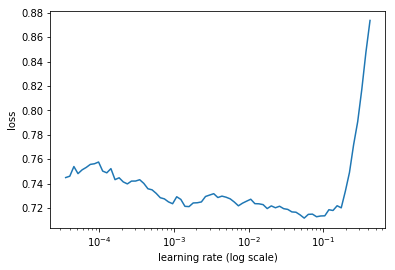

In [263]:
learn.lr_find(lrs/1000)
learn.sched.plot()

In [264]:
lrs = 5e-2

In [265]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.681524   0.650897   0.606812  



[0.6508973751749311, 0.606812162058694]

In [266]:
learn.save('clas_0')

In [267]:
learn.load('clas_0')

In [268]:
learn.freeze_to(-2)

In [269]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.673592   0.674057   0.572751  



[0.6740570919854301, 0.5727513219629016]

In [271]:
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [272]:
learn.fit(lrs, 1, wds=wd, cycle_len=14, use_clr=(32,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=14), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.603622   2.29852    0.576389  
    1      0.608366   7.834564   0.573413                    
    2      0.606213   0.70147    0.595238                    
    3      0.600061   0.710632   0.582341                    
    4      0.611266   0.644456   0.595238                    
    5      0.610971   0.651843   0.586971                    
    6      0.611401   0.649413   0.590608                    
    7      0.603971   0.645054   0.605489                    
    8      0.611684   0.826125   0.587632                    
    9      0.603468   2.090982   0.607804                    
    10     0.603244   1.25904    0.611442                    
    11     0.620156   0.640724   0.619048                    
    12     0.60379    1.975962   0.604828                    
    13     0.603165   0.64839    0.605489                    



[0.6483896459851947, 0.605489411524364]